# Lab 3 Overview
## First Half
- Linear Regression.
- Evaluation Metrics.
- Penalized Regression (LASSO and Ridge).
- Generalised Linear Models (GLM).
- Discussion.

## Second Half
Revision:
- Any code related questions for Python.
- (Windows 10 Users) Installing WSL2 (Ubuntu 20.04) for a clean environment.

Advanced Content:
- Introduction to `PySpark` continued.

-----------

### Regression in Python
- Linear Regression.
- General Linear Models (more covered in MAST30027).
- LASSO and Ridge Regression .
- Non-parametric models as alternatives.

___________________

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from statsmodels.formula.api import *

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_pickle("../data/lab_specific/sample.pkl")
df.dtypes

VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
RatecodeID                 int64
store_and_fwd_flag        object
dropoff_longitude        float64
dropoff_latitude         float64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
pickupX                  float64
pickupY                  float64
dropoffX                 float64
dropoffY                 float64
dtype: object

As an example, let's try to predict `total_amount` using `fare_amount, tip_amount, toll_amount, trip_distance, VendorID` as predictors.

Some things to take note:
- `tip_amount` is only valid for `payment_type == 1` (card)
- `VendorID` is categorical, with only two possible values (`1` or `2`) so we should make it boolean

In [3]:
# filter dataframe
COL_FILTER = ['total_amount', 'fare_amount', 'tip_amount', 'tolls_amount', 'trip_distance', 'VendorID']
df_filtered = df.loc[df['payment_type'] == 1, COL_FILTER].reset_index(drop=True)

# same as df_filtered['VendorID'].astype(bool)
df_filtered['VendorID'] = df_filtered['VendorID'] == 1 

df_filtered.tail()

,total_amount,fare_amount,tip_amount,tolls_amount,trip_distance,VendorID
65616,38.68,30.0,1.84,5.54,9.88,False
65617,45.80,38.5,6.00,0.00,12.75,False
65618,8.75,6.0,1.45,0.00,0.80,True
65619,23.76,18.5,3.96,0.00,4.73,False
65620,6.96,4.5,1.16,0.00,0.80,False


- We are looking for linear relationships between our chosen response `total_amount`.   
- Now I'm not sure what kind of life you've lived, but I'm fairly certain that we can infer that `total_amount` will have a positive linear relationship with `fare_amount`. Let's see a quick plot...

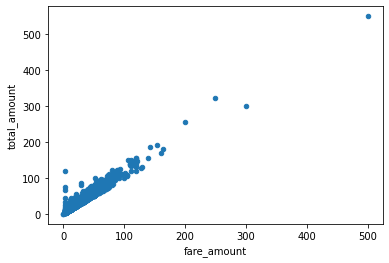

In [4]:
df_filtered[['total_amount', 'fare_amount']].plot.scatter(x='fare_amount', y='total_amount')
plt.show()

Well, obviously this looks like an overall positive linear relationship.
- How might we statistically test this?

-------

In R, we would do something like this for (Ordinary) Least Squares:
```R
>>> fit <- lm(total_amount~fare_amount + tip_amount + tolls_amount + trip_distance + VendorID ,data=dat_fit)
>>> summary(fit)
```
```
Call:
lm(formula = total_amount ~ fare_amount + tip_amount + tolls_amount +
trip_distance + VendorID, data = dat_fit)

Residuals:
Min     1Q      Median  3Q     Max
-1.4727 -0.3295 -0.1528 0.1747 1.7975

Coefficients:
               Estimate Std. Error t value Pr(>|t|)
(Intercept)    1.162154   0.002986 389.194  <2e-16 ***
fare_amount    0.993388   0.000315 3153.943 <2e-16 ***
tip_amount     1.006511   0.000826 1218.553 <2e-16 ***
tolls_amount   0.979325   0.001285 762.428  <2e-16 ***
trip_distance  0.011742   0.000963 12.194   <2e-16 ***
VendorIDTRUE  -0.003125   0.002914 -1.073    0.283
---
Signif. codes:
0 ^a˘A¨Y***^a˘A´Z 0.001 ^a˘A¨Y**^a˘A´Z 0.01 ^a˘A¨Y*^a˘A´Z 0.05 ^a˘A¨Y.^a˘A´Z 0.1 ^a˘A¨Y ^a˘A´Z 1

Residual standard error: 0.362 on 61886 degrees of freedom
Multiple R-squared: 0.9994,          Adjusted R-squared: 0.9994
F-statistic: 1.953e+07 on 5 and 61886 DF, p-value: < 2.2e-16
```

Well, whatever you can do in R can also done in Python (to an extent).  
Documentation Source: https://www.statsmodels.org/dev/generated/statsmodels.formula.api.ols.html?highlight=ols

In [5]:
fit = ols(formula="total_amount ~ fare_amount + tip_amount + tolls_amount + trip_distance + VendorID",
         data=df_filtered).fit()

In [6]:
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.113e+07
Date:                Mon, 07 Jun 2021   Prob (F-statistic):               0.00
Time:                        13:40:05   Log-Likelihood:                 5322.1
No. Observations:               65621   AIC:                        -1.063e+04
Df Residuals:                   65615   BIC:                        -1.058e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.4654      0.002  

- The table structure is a bit different, though it is identical in value with R's output.  
- The coefficient table is the same, but now includes a 95% CI for the beta coefficients.



___________________

Questions:
- Is this model good?
    - The $R^2$ value is 0.999 which is insanely large. As a rule of thumb, large $R^2$ values indicate a good fit. 
    - *Perhaps too good of a fit...*
    - AIC itself isn't important, however, if we compare it to another model (let's say an alternative model with different features chosen)...
    - If we have a hypothesis for a null model ($\beta=0$) vs our fitted model ($\beta\neq0$), then we can look at the `F-statistc = 1.953e+07`. The corresponding p-value of  this F statistic is `0.00`, which is less than $\alpha=0.05$, so we can conclude that our fitted model is better than a null model. In other words, we reject the null hypothesis and conclude that we believe the intercept parameters to be non-zero.
    
    
- How might we improve this model?
    - If we look at the parameters, we may wish to exclude `VendorID[T.True]` as it is not significant with p-value `0.283 > 0.05`. Perhaps we should drop this attribute and fit another model without it.
    - Additionally, we can do some feature engineering (run a decision tree and look at the splits)

In [7]:
fitter = ols(formula="total_amount ~ fare_amount + tip_amount + tolls_amount",
         data=df_filtered).fit()
print(fitter.summary())

                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.844e+07
Date:                Mon, 07 Jun 2021   Prob (F-statistic):               0.00
Time:                        13:40:05   Log-Likelihood:                 5273.9
No. Observations:               65621   AIC:                        -1.054e+04
Df Residuals:                   65617   BIC:                        -1.050e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.4657      0.002    940.683   

___________________

Now that we have to values of AIC to compare with, which one is better...?
- Well, we see a small decrease in AIC and a large decrease in BIC. Hence, we can say that the model without `VendorID` is better.

In [8]:
[fit.aic, fitter.aic], [fit.bic, fitter.bic]

([-10632.271532677914, -10539.899110559505],
 [-10577.721626403982, -10503.532506376883])

----------

### Penalized Regression
- LASSO (l1) and Ridge (l2) Regression

Revise in your own time if you've forgotten (this was covered in MAST30025):
- Lecture 4 (variable selection)
- LSM topic 5 (`ch05_handout`) slide 141/141

Things you might have forgotten when working with penalized models:
- Always good to standardize your data prior to train and test. Most models perform poorly if not standardized prior. 
- Do not fit your standardizer to test, only to train. You should transform both your train and test though.

### LASSO ($\ell_1$)
Quick overview:
- LASSO may cause coefficients to be set to 0 by constraining the model.
- This is because we put a constraint where the sum of the absolute values of the coefficients must be less than some fixed value. 
- As such, some coefficients may end up having 0 which is the same as *dropping* the attribute from the model.
- In this sense, it's quite similar to feature selection as you end up with a model that is much more simpler. 
- However, LASSO does not do well when the feature space is small as you may end up with an over-simplified model, as well as cases where all the featuers are significant or when coefficients are extremely large. 

Solution:
- Requires an iterative method to solve $(\mathbf{y}-X\beta)^T(\mathbf{y}-X\beta) + \lambda I \beta$

### Ridge ($\ell_2$)
Quick overview:
- Also know as the MAP (Maximum a posteriori) estimation.
- Aims to lower the scale of the coefficients to avoid overfitting, but does not result in coefficients being 0.
- In contraast to LASSO, we put a constrain using the sum of squares that must be lest than a fixed value. 
- As you might guess, this means we still have several features making it less interpretable than LASSO.
- However, Ridge Regression performs best in cases where there may be high multi-colinearity (i.e dependencies between attributes) or high linear correlation between certain attributes,
- This is because it reduces variance in exchange for some more bias (consider variance-bias tradeoff).
- You must also ensure that we have more observations than attributes (`n > p`) as this penalty method does not drop features, leading to worse predictions. 

Solution:
- Closed-form which can be found by minimising $(\mathbf{y}-X\beta)^T(\mathbf{y}-X\beta) + \lambda I \beta^T\beta$

In [9]:
yCOLS = ['total_amount']
xCOLS = ['fare_amount', 'tip_amount', 'tolls_amount', 'trip_distance', 'VendorID']

# standardize (by calculating the zscore) so our data has mean 0 and var 1
# alternatively, you can use sklearn's StandardScalar

from scipy.stats import zscore
df_standard = df_filtered[xCOLS].astype(float).apply(zscore)

In [10]:
# format output to 4 decimal places
pd.options.display.float_format = '{:,.4f}'.format
df_standard.describe().loc[['mean','std']]

,fare_amount,tip_amount,tolls_amount,trip_distance,VendorID
mean,-0.0000,0.0000,0.0000,0.0000,0.0000
std,1.0000,1.0000,1.0000,1.0000,1.0000


As you can see, `df_standard` has  $\mu=0, \sigma=1(=\sigma^2)$  

In [11]:
from glmnet import ElasticNet

lasso_fit = ElasticNet()
lasso_fit.fit(df_standard.values, df_filtered[yCOLS].values)

ElasticNet()

Now, we want to look at the shrinking parameter $\lambda$.  

In [12]:
# this can be accessed using the .lambda_best_ method after fitting!
print(f'Best lambda value for LASSO: {lasso_fit.lambda_best_[0]}')

Best lambda value for LASSO: 0.27198196216152276


$\lambda$ is computed by using cross validation (iterative approach).

What about our coefficients?
- https://github.com/civisanalytics/python-glmnet/blob/master/glmnet/linear.py

In [13]:
pd.DataFrame(index = ['Intercept'] + xCOLS, 
             data= [lasso_fit.intercept_] + list(lasso_fit.coef_), 
             columns = ['Coefficient'])

,Coefficient
Intercept,17.5665
fare_amount,9.8504
tip_amount,2.1925
tolls_amount,1.0554
trip_distance,0.0000
VendorID,0.0000


As you can see, `trip_distance` and `VendorID` have *shrunk* to 0. You can use `lasso_fit.predict(x)` to the predict a new set of observations by passing through the `x` matrix

___________________

### Fitting a GLM (Optional)
- Well, this is exactly what some of you will be learning in MAST30027 right now.

Let's go through an example:
- The `passenger_count` attribute is discrete and non-negative. If we were to predict it, a linear model will not be sufficient. 
- We know that a Poisson distribution takes in non-negative integer values, so we can use the Poisson family of GLMs to model this. 
- We will use `total_amount, trip_distance, VendorID` as our regressors.

For those of you not taking MAST30027 (ELI5):
- GLM's allow us to express relationships in a linear and additive way like normal linear regression.
- However, it might be the case that the underlying true relationship is neither linear nor additive. 
- The transformation is done through a *link function* (in this case, Poisson).

In [14]:
from statsmodels.api import families

# convert VendorID to categorical
df['VendorID'] = df['VendorID'] == 1

fit = glm(formula="passenger_count ~ total_amount + trip_distance + VendorID",
         data=df, family=families.Poisson()).fit()

print(fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        passenger_count   No. Observations:                98507
Model:                            GLM   Df Residuals:                    98503
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.4793e+05
Date:                Mon, 07 Jun 2021   Deviance:                       67982.
Time:                        13:40:06   Pearson chi2:                 8.34e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.7066      0.005  

- We can see that `total_amount` is insignificant (`p-val=0.124>0.05`)
- Conclude that the total fare amount does not really affect the number of passengers in a trip

--------

### Discussion
- What is the Bias-Variance tradeoff with respect to linear models:
    - Less parameters = less variance but more bias
    - More parameters = more variaance but less bias
    - The goal depends on the problem, but generalled we want an even variaance and bias (intersection).

- Is using regression on X attribute / specific dataset even a good choice...?
    - The answer is yes, it is a good choice *to try*
    - BUT also try other methods...
    
    
- What are the pros and cons of stepwise regression?
    - Forward Selection (start from nothing and end until significant)
    - Backward Elimination (start with everything and end until no more can be removed)
    - Not always the best results...
    
    
- What is best subset regression and the pros and cons of it?
    - A brute-force like method of fitting *all posssible regressuibs* or *all possible models*
    - Unlike stepwise, this method fits all possible models based on the variables specified, so you will get the best model possible
    ![test](https://i.kym-cdn.com/photos/images/newsfeed/001/718/138/147.jpg)
    
    
    
- What is an assumption we make when we fit linear regression models?
    - Well, the data has to be linearly seperable. 
    - Does this also apply to other models too...? (Recall SVM and kernel function which we can use)
    - Perhaps another model might suit the dataset... (Trees, Neural Networks, Clustering, etc...)
    
    
- If you were to use a decision tree, how would you compare between two different fits? 
    - Look at Gini Impurity (probability of an incorrectly classified instance)
    

- How about baselines or other predictive machine learning models?
    - Precision, Recall, Classification Accuracy...

-----------

### Feature Engineering?
- We want to see if the the profitability of zones remains consistent with respect to hour of day, day of week and pickup location. The distribution of profitable zones should be similar across all years.
- How is a zone profitable? Frequency of trips? Duration of trips? Best "earners"? 

- You could create your own feature and scale it accordingly. Perhaps the expected dollar per minute + possible tolls scaled by the expected frequency of trips might be a good start.

- Just remember that trip frequency $\approx$ taxi demand in a zone (you don't know the number of taxis in a zone at the time)

- Additionally, variable rate fares exist: *"50 cents per 1/5 mile when travelling above 12mph OR 50 cents per 60 seconds in slow traffic or when the vehicle is stopped."*

- Profit rates might assume crude approximations degrading into linear distance / constant velocity / etc

## Pre-Requisite Tasks for the Apache Spark tutorial

### WSL Environment for Windows 10
Refer to this guide to get a native Linux terminal in Windows 10:
- https://github.com/akiratwang/COMP20003-Setting-Up
- Ignore all the `C` related parts, just get Ubuntu installed.

### Apache Spark 3.0 (PySpark) Installation
- Visit `MAST30034/advanced_tutorials/Spark%20Installation.ipynb`

## Today
### Apache Spark 3.0 (PySpark and Spark SQL) Tutorial - Continued
- Visit `MAST30034/advanced_tutorials/Spark%20Tutorial.ipynb`